In [133]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

'''
The titanic data set contains three tables 
(1) train - the training data containing informations for all the passengers: Name, PassengerClass (Pclass), Sex, Age, SibSp, Parch, Ticket Number (Ticket), Fare, Cabin, Port of Embarkment (Embarked)
(2) gender - example prediction output where all the instances are female passengers
(3) test - same format as the training data, but used for 
'''

test = pd.read_csv('data/test.csv')
gender = pd.read_csv('data/gender_submission.csv')
train = pd.read_csv('data/train.csv')


In [134]:
'''
EDA + partially cleaning the data
''' 

# train dataset contains the Name, Sex, Age, etc, basic information 
# print(train.info())

'''
check for NaN (null) data by columns
'''
# Cabin and Age have a lot of Null values 

'''
because Cabin has poor data quality and we are not interested in Embarked, we can just drop them
'''
# table without Cabin and Embarked 
dropped = train.drop(['Cabin', 'Embarked'], axis=1)
test_dropped = test.drop(['Cabin', 'Embarked'], axis=1)

# another version of the table without invalid Age value 
filtered_age = dropped[dropped['Age'].notnull()]
print(filtered_age.info())
print(filtered_age.describe())

test_filtered_age = test_dropped[test_dropped['Age'].notnull()]
print(test_filtered_age.info())
print(test_filtered_age.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Name         714 non-null    object 
 4   Sex          714 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        714 non-null    int64  
 7   Parch        714 non-null    int64  
 8   Ticket       714 non-null    object 
 9   Fare         714 non-null    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 61.4+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   714.000000  714.000000  714.000000  714.000000  714.000000   
mean    448.582633    0.406162    2.236695   29.699118    0.512605   
std     259.119524    0.491460    0.838250   14.526497    0.929783   
min       1.000000    0.000000    1.000000 

<AxesSubplot:xlabel='Fare', ylabel='Count'>

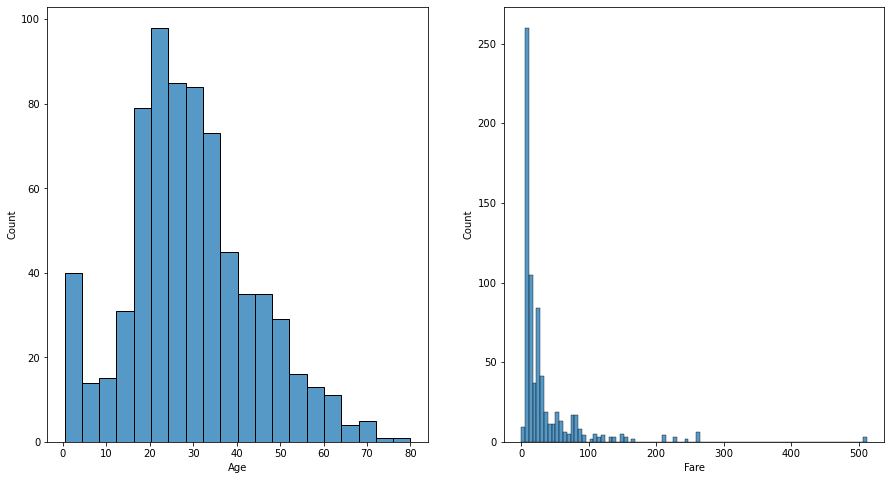

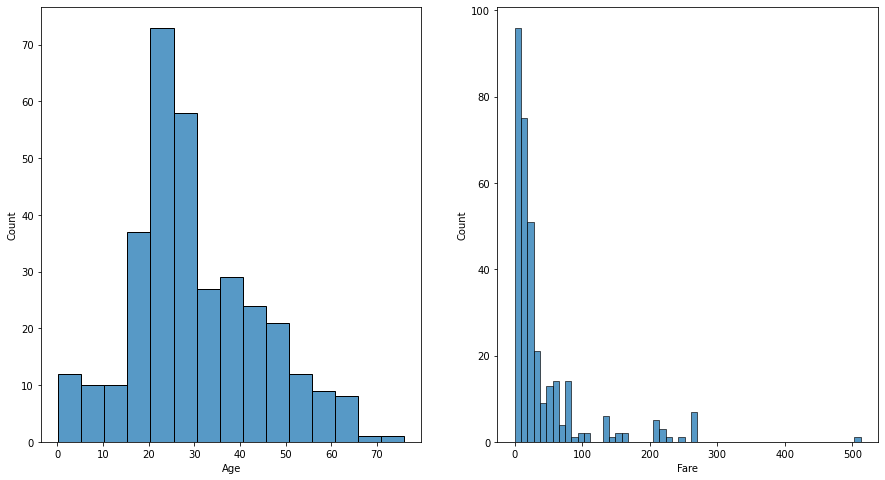

In [135]:
'''
Visualization (Seaborn: https://seaborn.pydata.org/introduction.html)
'''
import seaborn as sns 

# looking at Fare and Age to define their categroy
f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))
sns.histplot(data=filtered_age['Age'], ax=axs[0])
sns.histplot(data=filtered_age['Fare'], ax=axs[1])

f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))
sns.histplot(data=test_filtered_age['Age'], ax=axs[0])
sns.histplot(data=test_filtered_age['Fare'], ax=axs[1])

<AxesSubplot:xlabel='Fare', ylabel='Count'>

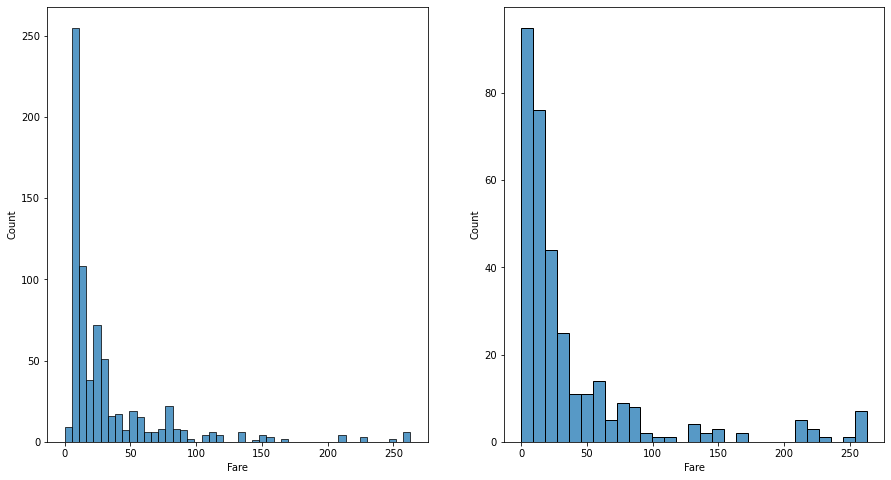

In [136]:
'''
Obivously, Fare has some outliers that need to be removed
'''
f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))

filtered_age = filtered_age[filtered_age["Fare"]<300]
sns.histplot(data=filtered_age['Fare'], ax=axs[0])

test_filtered_age = test_filtered_age[test_filtered_age["Fare"]<300]
sns.histplot(data=test_filtered_age['Fare'], ax=axs[1])

In [189]:
'''
build classifier (Scikit-Learn: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn)
'''
from sklearn import preprocessing

# first define (encode) the features 
# we are interested in the following features: Sex, Age, passenger class, fare

names = ['Sex', 'Age', 'Pclass', 'Fare']
features = filtered_age[['Sex', 'Age', 'Pclass', 'Fare']].to_numpy()

# training list 
label = filtered_age['Survived'].to_numpy()

# testing features 
test_features = test_filtered_age[['Sex', 'Age', 'Pclass', 'Fare']].to_numpy()

# varify they are the same shape 
assert(features.shape[0] == label.shape[0])

'''
Once we are all good with our data, we can encode them using sklearn
'''

# encode the labeling features
# this convert string, boolean data into int
le = preprocessing.LabelEncoder()

# Sex needs to be encoded 
sex_encoded = le.fit_transform([feature[0] for feature in features])
test_sex_encoded = le.fit_transform([t_feature[0] for t_feature in test_features])

assert(sex_encoded.shape[0] == label.shape[0])


# all the other features are already in int or floats
# now we merge the encoded feature back 
for i in range(len(features)):
    features[i][0] = sex_encoded[i]

for i in range(len(test_features)):
    test_features[i][0] = test_sex_encoded[i]

'''
Age and Fare needs to be converted into catagorical data 
conversion rule: 
* (Age) 0: [0-5]; 1: [6-11]; ...; total of 8 levels --> Age // 5
* (Fare) 0: [0-10]; 1: [11-21]; ...; total of 28 levels --> Fare // 10
'''
for feature in features:
    # catagorizes Age
    feature[1] = feature[1] // 5
    # catagorizes Fare
    feature[3] = feature[3] // 10

for test_feature in test_features:
    # catagorizes Age
    test_feature[1] = test_feature[1] // 5
    # catagorizes Fare
    test_feature[3] = test_feature[3] // 10 


# print(np.isnan(np.sum(test_features)))



In [190]:
'''
fit the model with Sex alone
'''
from sklearn.naive_bayes import GaussianNB

gnb_sex = GaussianNB()
gnb.fit([[i] for i in sex_encoded], label)

prediction = gnb.predict([[i] for i in test_sex_encoded])
prediction

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,

[0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1
 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1
 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0]
